# Telecom Churn | Predictive Analytics

**Background:** There are many variables in this dataset so the most important part of this process is to reduce the number of variables **to avoid overfitting** and **to avoid the curse of dimensionality**. We will compare 3 algorithms (Random Forest, Gradient Boosting, SVM) and use the most appropriate model to predict churn as well as use the most important features to take actionable steps.

**Analysis Objective:** After creating, training, cross validating our model, we want our client to be able to **take action on current customers** (ex: sending specific promotional, gratituous offers etc) **to reduce churn rate**.

### Import modules

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns

In [2]:
churn = 'churn.csv' # import data
df = pd.read_csv(churn)
df = df.iloc[:, 1:]
df = df.drop(['customerID'],axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,142,2505,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,498,1466,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,436,157,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,266,1400,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,729,925,1


## Normalize Features

In [3]:
# prep for normalizing
X = df.iloc[:,0:19].values
y = df.iloc[:,19].values

# normalize so prediction on features will be on same scale
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
dfNorm = pd.DataFrame(X_std, index=df.index, columns=df.columns[0:19])

# add target variable to dataframe
dfNorm['churn'] = df['Churn']

# prep X and y arrays
X = dfNorm.iloc[:,0:19].values
y = dfNorm.iloc[:,19].values

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Create Training and Test Data

In [4]:
# create training data to tune model and test data to validate/test w/ unseen data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, y_train.shape, X_test.shape , y_test.shape

((5634, 19), (5634,), (1409, 19), (1409,))

## Create Model Functions

In [5]:
from sklearn import cross_validation, metrics # Additional scklearn functions

def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dfNorm[predictors], dfNorm['churn'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dfNorm[predictors])
    dtrain_predprob = alg.predict_proba(dfNorm[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dfNorm[predictors], dfNorm['churn'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dfNorm['churn'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dfNorm['churn'], dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Random Forest Classifier

**Model Explanation:** The Random Forest is an ensemble method of the decision tree. The goal of a decision tree is to determine branches that reduce the residual sums of squares the most, and provide the most predictive leaves as possible -- growing branches that reduce classification error.

We look across all trees to see how many times that observation was predicted. A class is then assigned to that observation if it is predicted from the majority of bagged trees. This works to decorrelate trees used in random forest, and is useful in automatically combating multi-collinearity.

We take an entropy-like measure, and try to reduce the amount of entropy at each branch to provide the best branch split. The Gini Index is a commonly used metric.

#### Random Hyperparameter Tuning

We are not trying every combination, but selecting at random to sample a wide range of values.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
predictors = ['gender','SeniorCitizen','Partner','Dependents','tenure','PhoneService','MultipleLines','InternetService',
              'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract',
             'PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges']

# Number of trees in random forest
n_estimators = list(range(200,2000,10))
# Gini or Entropy to measure quality of split
# Gini(better for continuous attributes) /Entropy (log based function, more computationally expensive, better for discrete attributes)
criterion = ['gini','entropy']
# Number of features to consider at every split 
# improves performance w/ more choices at each leaf but also decreases diversity of each tree.
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = list(range(10,110,10))
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
# smaller leaf makes the model more prone to capturing noise in train data
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]



# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [7]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(dfNorm[predictors], dfNorm['churn'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=1180, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=40, criterion=gini, bootstrap=False 
[CV] n_estimators=1180, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=40, criterion=gini, bootstrap=False 
[CV] n_estimators=1180, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=40, criterion=gini, bootstrap=False 
[CV] n_estimators=1870, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=90, criterion=gini, bootstrap=False 
[CV]  n_estimators=1180, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=40, criterion=gini, bootstrap=False, total=  17.3s
[CV] n_estimators=1870, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=90, criterion=gini, bootstrap=False 
[CV]  n_estimators=1180, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=40, criterion=gini, bootstrap=Fals

[CV] n_estimators=1660, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, criterion=entropy, bootstrap=False 
[CV]  n_estimators=1780, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=None, criterion=entropy, bootstrap=False, total=  35.3s
[CV] n_estimators=1660, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, criterion=entropy, bootstrap=False 
[CV]  n_estimators=1780, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=None, criterion=entropy, bootstrap=False, total=  31.6s
[CV] n_estimators=380, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=80, criterion=entropy, bootstrap=True 
[CV]  n_estimators=380, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=80, criterion=entropy, bootstrap=True, total=   5.3s
[CV] n_estimators=380, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=80, criterion=entropy, bootstrap=True 
[CV]  n_estimators=

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min


[CV]  n_estimators=1660, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, criterion=entropy, bootstrap=False, total=  27.9s
[CV] n_estimators=670, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, criterion=gini, bootstrap=False 
[CV]  n_estimators=380, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=80, criterion=entropy, bootstrap=True, total=   5.7s
[CV] n_estimators=670, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, criterion=gini, bootstrap=False 
[CV]  n_estimators=1660, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=20, criterion=entropy, bootstrap=False, total=  27.4s
[CV] n_estimators=1640, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=40, criterion=gini, bootstrap=False 
[CV]  n_estimators=670, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=20, criterion=gini, bootstrap=False, total=   9.6s
[CV] n_estimato

[CV] n_estimators=1870, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=70, criterion=entropy, bootstrap=False 
[CV]  n_estimators=1750, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=20, criterion=entropy, bootstrap=True, total=  23.9s
[CV] n_estimators=1870, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=70, criterion=entropy, bootstrap=False 
[CV]  n_estimators=1750, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=20, criterion=entropy, bootstrap=True, total=  23.7s
[CV] n_estimators=1870, min_samples_split=2, min_samples_leaf=4, max_features=log2, max_depth=70, criterion=entropy, bootstrap=False 
[CV]  n_estimators=1750, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=20, criterion=entropy, bootstrap=True, total=  23.7s
[CV] n_estimators=1450, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=30, criterion=entropy, bootstrap=True 
[CV]  n_estimators=18

[CV]  n_estimators=1640, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=90, criterion=entropy, bootstrap=False, total=  30.8s
[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, criterion=gini, bootstrap=False 
[CV]  n_estimators=1280, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=50, criterion=gini, bootstrap=False, total=  19.5s
[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, criterion=gini, bootstrap=False 
[CV]  n_estimators=1280, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=50, criterion=gini, bootstrap=False, total=  20.4s
[CV] n_estimators=1500, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=None, criterion=gini, bootstrap=False 
[CV]  n_estimators=1280, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=50, criterion=gini, bootstrap=False, total=  20.5s
[CV] n_est

[CV] n_estimators=410, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=50, criterion=gini, bootstrap=False 
[CV]  n_estimators=1620, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, criterion=entropy, bootstrap=False, total=  32.4s
[CV] n_estimators=740, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, criterion=entropy, bootstrap=True 
[CV]  n_estimators=1620, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=70, criterion=entropy, bootstrap=False, total=  32.6s
[CV] n_estimators=740, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, criterion=entropy, bootstrap=True 
[CV]  n_estimators=410, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=50, criterion=gini, bootstrap=False, total=   6.3s
[CV] n_estimators=740, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=70, criterion=entropy, bootstrap=True 
[CV]  n_estimators=410, mi

[CV]  n_estimators=740, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=30, criterion=gini, bootstrap=True, total=  10.2s
[CV] n_estimators=1720, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, criterion=entropy, bootstrap=True 
[CV]  n_estimators=740, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=30, criterion=gini, bootstrap=True, total=  10.3s
[CV] n_estimators=1300, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, criterion=gini, bootstrap=True 
[CV]  n_estimators=1300, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, criterion=gini, bootstrap=True, total=  14.7s
[CV] n_estimators=1300, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, criterion=gini, bootstrap=True 


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 12.8min


[CV]  n_estimators=1720, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, criterion=entropy, bootstrap=True, total=  24.0s
[CV] n_estimators=1300, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=10, criterion=gini, bootstrap=True 
[CV]  n_estimators=1720, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, criterion=entropy, bootstrap=True, total=  24.3s
[CV] n_estimators=460, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, criterion=gini, bootstrap=True 
[CV]  n_estimators=1720, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=40, criterion=entropy, bootstrap=True, total=  23.9s
[CV] n_estimators=460, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, criterion=gini, bootstrap=True 
[CV]  n_estimators=460, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, criterion=gini, bootstrap=True, total=   5.4s
[CV] n_estimators=460

[CV] n_estimators=1280, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=40, criterion=entropy, bootstrap=True 
[CV]  n_estimators=1280, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=40, criterion=entropy, bootstrap=True, total=  18.3s
[CV] n_estimators=1280, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=40, criterion=entropy, bootstrap=True 
[CV]  n_estimators=1890, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=100, criterion=gini, bootstrap=False, total=  25.3s
[CV]  n_estimators=1890, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=100, criterion=gini, bootstrap=False, total=  25.4s
[CV] n_estimators=630, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=40, criterion=gini, bootstrap=False 
[CV] n_estimators=630, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=40, criterion=gini, bootstrap=False 
[CV]  n_estimators=1280, min_s

[CV]  n_estimators=1770, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, criterion=entropy, bootstrap=True, total=  23.6s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, criterion=gini, bootstrap=True 
[CV]  n_estimators=1770, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, criterion=entropy, bootstrap=True, total=  23.2s
[CV] n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, criterion=gini, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, criterion=gini, bootstrap=True, total=  13.3s
[CV] n_estimators=330, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=80, criterion=entropy, bootstrap=False 
[CV]  n_estimators=330, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=80, criterion=entropy, bootstrap=False, total=   5.4s
[CV] n_estimators=

[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, criterion=entropy, bootstrap=False 
[CV]  n_estimators=1290, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=30, criterion=entropy, bootstrap=False, total=  23.2s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, criterion=entropy, bootstrap=False 
[CV]  n_estimators=1720, min_samples_split=10, min_samples_leaf=4, max_features=log2, max_depth=20, criterion=gini, bootstrap=True, total=  18.7s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, criterion=entropy, bootstrap=False 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=40, criterion=entropy, bootstrap=False, total=  17.3s
[CV] n_estimators=1010, min_samples_split=10, min_samples_leaf=2, max_features=log2, max_depth=90, criterion=entropy, bootstrap=False 
[CV]  n_estimators=900,

[CV]  n_estimators=970, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=90, criterion=gini, bootstrap=True, total=   9.9s
[CV] n_estimators=1360, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, criterion=gini, bootstrap=True 
[CV]  n_estimators=1470, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=80, criterion=entropy, bootstrap=True, total=  19.0s
[CV] n_estimators=1360, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, criterion=gini, bootstrap=True 
[CV]  n_estimators=1360, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, criterion=gini, bootstrap=True, total=  13.1s
[CV] n_estimators=1360, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=10, criterion=gini, bootstrap=True 
[CV]  n_estimators=1470, min_samples_split=2, min_samples_leaf=2, max_features=log2, max_depth=80, criterion=entropy, bootstrap=True, total=  18.7s
[CV] n_estimators=17

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 22.7min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 72..., None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', ra

#### Best Parameters

In [8]:
rf_random.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 670}

#### Evaluate Random Search

To determine if random search yielded a better model, we compare the base model with the best random search model.


Model Report
Accuracy : 0.9804
AUC Score (Train): 0.998728
CV Score : Mean - 0.7912972 | Std - 0.01312693 | Min - 0.7697667 | Max - 0.8091917


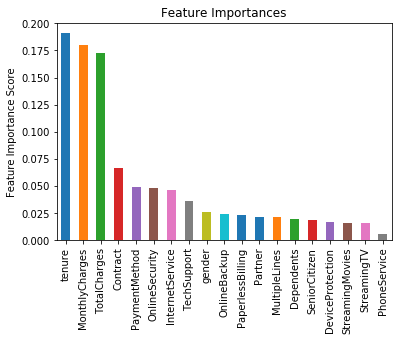

In [9]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
modelfit(base_model, dfNorm, predictors)


Model Report
Accuracy : 0.854
AUC Score (Train): 0.927192
CV Score : Mean - 0.8443983 | Std - 0.01223308 | Min - 0.8280917 | Max - 0.8583818


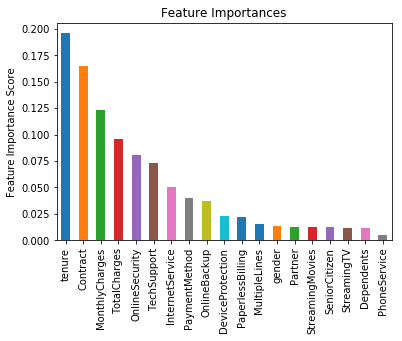

In [10]:
best_random = rf_random.best_estimator_
modelfit(best_random, dfNorm, predictors)

Our model improved 3% which is awesome. Now we can further tune our model using cross validation over a grid search.

#### Grid Search w/ Cross Validation

Since our parameters are narrowed down, we can concentrate our search w/ Cross Validation

In [11]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 

param_grid = {
    'bootstrap': [True],
    'criterion': ['entropy'],
    'max_depth': [70,75, 80],
    'max_features': ['log2'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 9, 10],
    'n_estimators': [550,650,750, 800]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=550 
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=550 
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=550 
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=650 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=550, total=   5.5s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=650 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=55

[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=750 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=650, total=   6.5s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=750 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=650, total=   6.7s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=750, total=   7.7s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=True, cr

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min


[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=800, total=   8.3s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=550 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=800, total=   8.4s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=550 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=550, total=   5.6s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=650 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=550, total=   5.7s
[CV] bootstrap

[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=750 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=650, total=   6.3s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=750 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=650, total=   6.1s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=750 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=650, total=   6.2s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=True, cr

[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=750, total=   7.7s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=800, total=   8.3s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=550, total=   6.5s
[CV] bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, criterion=entropy, max_depth=70, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=800, total=   9.5s
[CV] bootstr

[CV] bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=3, min_samples_split=9, n_estimators=650 
[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=3, min_samples_split=9, n_estimators=550, total=   5.1s
[CV] bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=3, min_samples_split=9, n_estimators=750 
[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=3, min_samples_split=9, n_estimators=650, total=   6.1s
[CV] bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=3, min_samples_split=9, n_estimators=750 
[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=3, min_samples_split=9, n_estimators=650, total=   6.1s
[CV] bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=3, min_samples_split=9, n_estimators=750 
[CV]  bootstrap=True, criterion

[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=750, total=   7.2s
[CV] bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=750, total=   7.1s
[CV] bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=550 
[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=800, total=   7.4s
[CV] bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=550 


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.8min


[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=550, total=   5.2s
[CV] bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=550 
[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=800, total=   7.8s
[CV] bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=650 
[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=550, total=   5.3s
[CV] bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=650 
[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=800, total=   7.6s
[CV] bootstrap=T

[CV] bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=750 
[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=650, total=   6.1s
[CV] bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=750 
[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=650, total=   6.2s
[CV] bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=750, total=   6.8s
[CV] bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=5, min_samples_split=8, n_estimators=800 
[CV]  bootstrap=True, criterion

[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=800, total=   7.8s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=550 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=550, total=   5.0s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=550 
[CV]  bootstrap=True, criterion=entropy, max_depth=75, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=800, total=   7.2s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=650 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=8, n_estimators=550, total=   5.1s
[CV] bootstrap

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=750 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=650, total=   6.9s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=750 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=650, total=   6.9s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=750 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=650, total=   6.8s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=3, min_samples_split=10, n_estimators=800 
[CV]  bootstrap=True, cr

[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=750, total=  10.6s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=800, total=  11.3s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=550, total=   5.1s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=550 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=4, min_samples_split=9, n_estimators=800, total=   8.6s
[CV] bootstr

[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=650 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=550, total=   5.3s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=750 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=650, total=   6.3s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=750 
[CV]  bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=650, total=   6.4s
[CV] bootstrap=True, criterion=entropy, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=9, n_estimators=750 
[CV]  bootstrap=True, criterion

[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 10.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'criterion': ['entropy'], 'max_depth': [70, 75, 80], 'max_features': ['log2'], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 9, 10], 'n_estimators': [550, 650, 750, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [12]:
grid_search.best_params_ # best parameters

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 75,
 'max_features': 'log2',
 'min_samples_leaf': 5,
 'min_samples_split': 8,
 'n_estimators': 550}

In [13]:
best_grid = grid_search.best_estimator_


Model Report
Accuracy : 0.8738
AUC Score (Train): 0.944844
CV Score : Mean - 0.8436328 | Std - 0.01236438 | Min - 0.8263815 | Max - 0.8575758


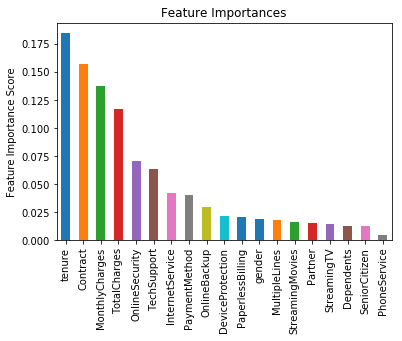

In [14]:
modelfit(best_grid, dfNorm, predictors)


## 2. Gradient Boosting Classifier

**Model Explanation:** Unlike bagging algorithms, which only controls for high variance in a model, boosting controls both the aspects (bias & variance), and is considered to be more effective.

**Boosting:** is a sequential technique which works on the principle of ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher.

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.grid_search import GridSearchCV # Perforing grid search
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Baseline Model


Model Report
Accuracy : 0.8229
AUC Score (Train): 0.876183
CV Score : Mean - 0.8453536 | Std - 0.00952831 | Min - 0.8317601 | Max - 0.8569118


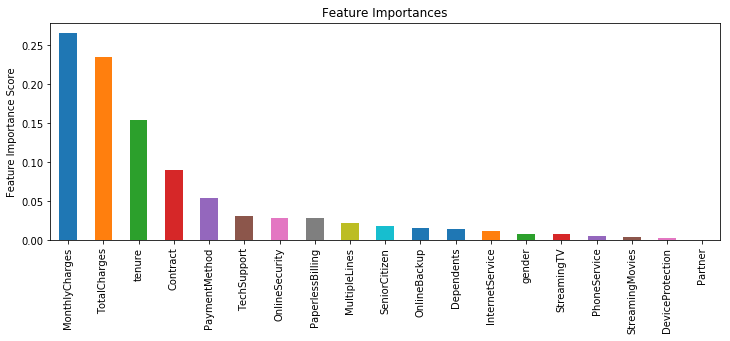

In [16]:
#### Choose all predictors except target & IDcols
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, dfNorm, predictors)

#### Tuning Boosting-Specific Parameters

This determines the impact of each tree on the final outcome. Lower values are generally preferred as they make the model robust to the specific characteristics of tree and thus allowing it to generalize well.
Lower values would require higher number of trees to model all the relations and will be computationally expensive.

### look into this

In [ ]:
#Choose all predictors except target & IDcols
param_test1 = {'n_estimators': list(range(20,81,10))}

#Choosing a moderate learning rate (anything less than 1 is ok) so that we avoid overfitting -- making less corrections for each tree added to the model, min_samples_split = 40 ~.5-1% of total values and since we have imbalanced class we will use .5%
#min_samples_leaf to avoid overfitting and small value because of imbalanced class
#max_depth usually 5-8 and since we have only 7k records, we'll use 5
#max_features general rule of thumb to use sqrt
#subsample .8 is a good start / general rule of thumb

gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, min_samples_split=40,min_samples_leaf=4,max_depth=5,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(dfNorm[predictors],dfNorm['churn'])


In [18]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.84540, std: 0.01006, params: {'n_estimators': 20},
  mean: 0.84742, std: 0.01096, params: {'n_estimators': 30},
  mean: 0.84762, std: 0.01099, params: {'n_estimators': 40},
  mean: 0.84761, std: 0.01083, params: {'n_estimators': 50},
  mean: 0.84830, std: 0.01080, params: {'n_estimators': 60},
  mean: 0.84822, std: 0.01102, params: {'n_estimators': 70},
  mean: 0.84795, std: 0.01125, params: {'n_estimators': 80}],
 {'n_estimators': 60},
 0.8482998855661006)

As you can see that here we got 60 as the optimal estimators for 0.05 learning rate. Note that 60 is a reasonable value and can be used as it is.

#### Tuning Tree-Specific Parameters

The order of tuning variables should be decided carefully. You should take the variables with a higher impact on outcome first. For instance, max_depth and min_samples_split have a significant impact and we’re tuning those first.

In [19]:
param_test2 = {'max_depth':list(range(3,9,2)), 'min_samples_split':list(range(50,350,50))}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(dfNorm[predictors],dfNorm['churn'])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.84586, std: 0.01071, params: {'max_depth': 3, 'min_samples_split': 50},
  mean: 0.84599, std: 0.01081, params: {'max_depth': 3, 'min_samples_split': 100},
  mean: 0.84591, std: 0.01076, params: {'max_depth': 3, 'min_samples_split': 150},
  mean: 0.84590, std: 0.01075, params: {'max_depth': 3, 'min_samples_split': 200},
  mean: 0.84602, std: 0.01069, params: {'max_depth': 3, 'min_samples_split': 250},
  mean: 0.84582, std: 0.01114, params: {'max_depth': 3, 'min_samples_split': 300},
  mean: 0.84686, std: 0.01026, params: {'max_depth': 5, 'min_samples_split': 50},
  mean: 0.84687, std: 0.01028, params: {'max_depth': 5, 'min_samples_split': 100},
  mean: 0.84797, std: 0.01020, params: {'max_depth': 5, 'min_samples_split': 150},
  mean: 0.84759, std: 0.01073, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.84735, std: 0.01044, params: {'max_depth': 5, 'min_samples_split': 250},
  mean: 0.84710, std: 0.01090, params: {'max_depth': 5, 'min_samples_split': 300},
  mean

We will add max depth of 5 to our parameters and search, by increments of 10, between 100 and 300 to get our min_samples_leaf value.

In [20]:
param_test3 = {'min_samples_split':list(range(100,300,10)), 'min_samples_leaf':list(range(40,55,5))}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=60,max_depth=5,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(dfNorm[predictors],dfNorm['churn'])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.84802, std: 0.01064, params: {'min_samples_leaf': 40, 'min_samples_split': 100},
  mean: 0.84729, std: 0.01083, params: {'min_samples_leaf': 40, 'min_samples_split': 110},
  mean: 0.84704, std: 0.01089, params: {'min_samples_leaf': 40, 'min_samples_split': 120},
  mean: 0.84719, std: 0.01026, params: {'min_samples_leaf': 40, 'min_samples_split': 130},
  mean: 0.84720, std: 0.01111, params: {'min_samples_leaf': 40, 'min_samples_split': 140},
  mean: 0.84741, std: 0.01082, params: {'min_samples_leaf': 40, 'min_samples_split': 150},
  mean: 0.84662, std: 0.01053, params: {'min_samples_leaf': 40, 'min_samples_split': 160},
  mean: 0.84699, std: 0.01036, params: {'min_samples_leaf': 40, 'min_samples_split': 170},
  mean: 0.84682, std: 0.00978, params: {'min_samples_leaf': 40, 'min_samples_split': 180},
  mean: 0.84674, std: 0.01025, params: {'min_samples_leaf': 40, 'min_samples_split': 190},
  mean: 0.84744, std: 0.01051, params: {'min_samples_leaf': 40, 'min_samples_split': 200},

Our min_samples_leaf is 50 and min_samples_split is now 230. Let's plug this in and take a look at our feature importance plot.


Model Report
Accuracy : 0.8149
AUC Score (Train): 0.867250
CV Score : Mean - 0.8483242 | Std - 0.01111833 | Min - 0.8332778 | Max - 0.8623886


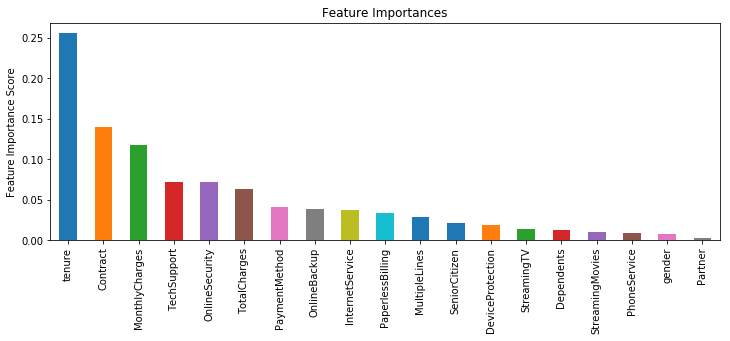

In [21]:
gbm1 = GradientBoostingClassifier(min_samples_split=230, min_samples_leaf=50, learning_rate=0.05, n_estimators=60,max_depth=5,max_features='sqrt', subsample=0.8, random_state=10)
modelfit(gbm1, dfNorm, predictors)

If you compare the feature importance of this model with the baseline model, you’ll find that now we are able to derive value from many more variables. Also, earlier it placed too much importance on some variables but now it has been fairly distributed.

Now let's tune the last tree parameter which is our max features.

In [22]:
param_test4 = {'max_features':list(range(1,8,1))}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.05, n_estimators=60,max_depth=5, min_samples_split=230, min_samples_leaf=50, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(dfNorm[predictors],dfNorm['churn'])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83765, std: 0.01081, params: {'max_features': 1},
  mean: 0.84454, std: 0.01113, params: {'max_features': 2},
  mean: 0.84727, std: 0.01129, params: {'max_features': 3},
  mean: 0.84832, std: 0.01112, params: {'max_features': 4},
  mean: 0.84820, std: 0.01108, params: {'max_features': 5},
  mean: 0.84801, std: 0.01092, params: {'max_features': 6},
  mean: 0.84802, std: 0.01120, params: {'max_features': 7}],
 {'max_features': 4},
 0.8483242484717737)

#### Tuning Subsample

In [23]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(max_features = 4, learning_rate=0.05, n_estimators=60,max_depth=5, min_samples_split=230, min_samples_leaf=50, subsample=0.8, random_state=10),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(dfNorm[predictors],dfNorm['churn'])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.84789, std: 0.01083, params: {'subsample': 0.6},
  mean: 0.84792, std: 0.01106, params: {'subsample': 0.7},
  mean: 0.84737, std: 0.01047, params: {'subsample': 0.75},
  mean: 0.84832, std: 0.01112, params: {'subsample': 0.8},
  mean: 0.84752, std: 0.01051, params: {'subsample': 0.85},
  mean: 0.84760, std: 0.01044, params: {'subsample': 0.9}],
 {'subsample': 0.8},
 0.8483242484717737)

Here, we found 0.8 as the optimum value. Finally, we have all the parameters needed. Now, we need to lower the learning rate and increase the number of estimators proportionally. Note that these trees might not be the most optimum values but a good benchmark.

#### Lowering Learning Rates

GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates.

As trees increase, it will become increasingly computationally expensive to perform CV and find the optimum values. Lets decrease the learning rate to half, i.e. 0.025 with twice (120) the number of trees.


Model Report
Accuracy : 0.8147
AUC Score (Train): 0.868251
CV Score : Mean - 0.848186 | Std - 0.01178582 | Min - 0.8320636 | Max - 0.8634336


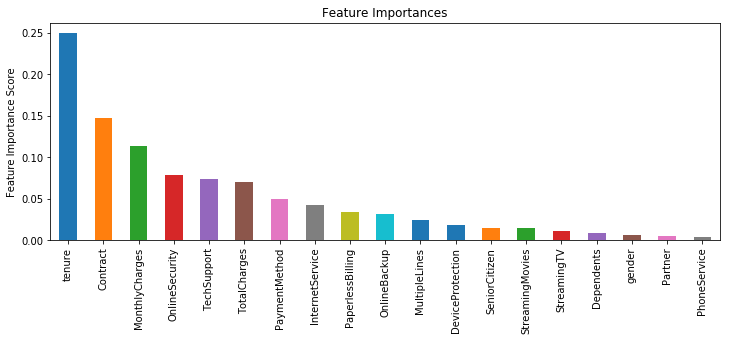

In [24]:
gbm_tuned_1 = GradientBoostingClassifier(max_features = 4, learning_rate=0.025, n_estimators=120,max_depth=5, min_samples_split=230, min_samples_leaf=50, subsample=0.8, random_state=10)
modelfit(gbm_tuned_1, dfNorm, predictors)

Now lets reduce to one-tenth of the original value, i.e. 0.005 for 600 trees.


Model Report
Accuracy : 0.8168
AUC Score (Train): 0.869007
CV Score : Mean - 0.8484829 | Std - 0.01089786 | Min - 0.8330052 | Max - 0.862572


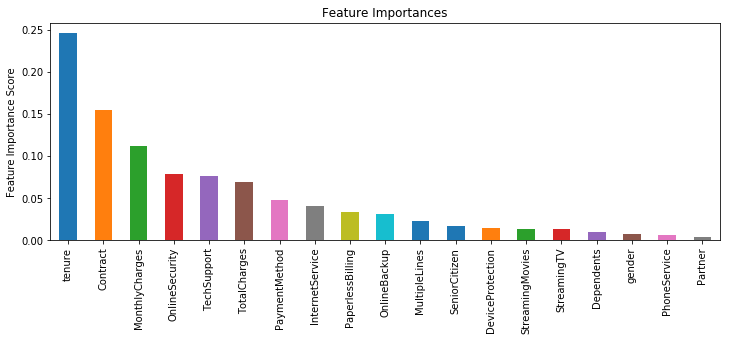

In [25]:
gbm_tuned_1 = GradientBoostingClassifier(max_features = 4, learning_rate=0.005, n_estimators=600,max_depth=5, min_samples_split=230, min_samples_leaf=50, subsample=0.8, random_state=10)
modelfit(gbm_tuned_1, dfNorm, predictors)

Lets decrease to one-twentieth of the original value, i.e. 0.005 for 1200 trees.


Model Report
Accuracy : 0.8157
AUC Score (Train): 0.868876
CV Score : Mean - 0.8483917 | Std - 0.01090811 | Min - 0.8332623 | Max - 0.8621793


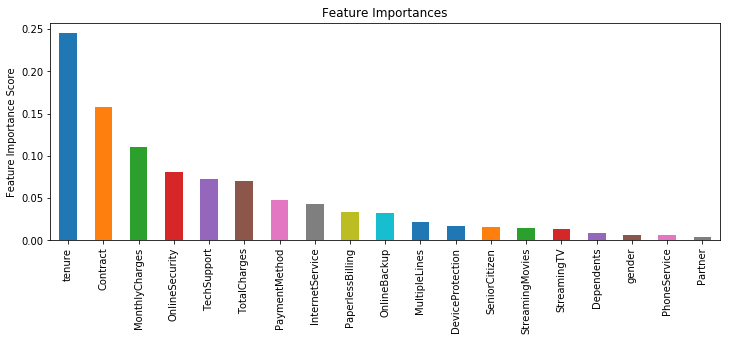

In [26]:
gbm_tuned_1 = GradientBoostingClassifier(max_features = 4, learning_rate=0.0025, n_estimators=1200,max_depth=5, min_samples_split=230, min_samples_leaf=50, subsample=0.8, random_state=10)
modelfit(gbm_tuned_1, dfNorm, predictors)

Here we see that the score reduced very slightly. So lets run for 1500 trees.


Model Report
Accuracy : 0.8191
AUC Score (Train): 0.871601
CV Score : Mean - 0.8485946 | Std - 0.01112533 | Min - 0.8326991 | Max - 0.8625384


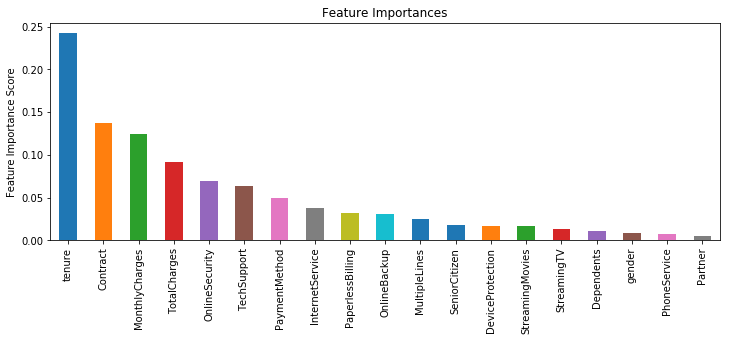

In [27]:
gbm_tuned_1 = GradientBoostingClassifier(max_features = 4, learning_rate=0.0025, n_estimators=1500,max_depth=5, min_samples_split=230, min_samples_leaf=50, subsample=0.8, random_state=10)
modelfit(gbm_tuned_1, dfNorm, predictors)

## 3. Support Vector Machine

**Model:** In this algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes very well. Support Vector Machine is a frontier which best segregates the two classes (hyper-plane/ line).

**Kernels**: These are functions which takes low dimensional input space and transform it to a higher dimensional space i.e. it converts not separable problem to separable problem, these functions are called kernels. It is mostly useful in non-linear separation problem. Simply put, it does some extremely complex data transformations, then find out the process to separate the data based on the labels or outputs you’ve defined.

#### Baseline Models

First, I will focus on the most impactful parameters to see which kernel is most effective. Then I will use that kernel and fine tune the other parameters using grid search and cross validation.

In [7]:
from sklearn import svm
model = svm.SVC(kernel='linear', C=1, gamma=1,probability=True) 
modelfit(model, dfNorm, predictors,printFeatureImportance=False)


Model Report
Accuracy : 0.8012
AUC Score (Train): 0.839814
CV Score : Mean - 0.8377413 | Std - 0.01079442 | Min - 0.8263518 | Max - 0.8520809


In [11]:
model = svm.SVC(kernel='rbf', C=1, gamma=1,probability=True) 
modelfit(model, dfNorm, predictors,printFeatureImportance=False)


Model Report
Accuracy : 0.9506
AUC Score (Train): 0.974431
CV Score : Mean - 0.7082278 | Std - 0.01134806 | Min - 0.6922047 | Max - 0.7216539


#### Tune Parameters

##### DISCLAIMER: I did not add ALL of the parameters because my computer takes VERY long to perform the gridsearch w/ just the following parameters.

In [8]:
# Penalty parameter C of the error term.
C = [1,100,1000]
# Degree of the polynomial kernel function
degree = [2,3,4]
# Higher the value of gamma, will try to exact fit the as per training data set i.e. generalization error and cause over-fitting problem.
gamma = [0,10,100]
# Specify the size of the kernel cache
cache_size = [200,500, 1000]
# for imbalanced classes
class_weight = [None,'balanced']

# Create the random grid
random_grid = {'C': C,
               'gamma': gamma,
               'cache_size': cache_size,
               'class_weight': class_weight,
              }

#### Linear Kernel

In [9]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
svmModel = svm.SVC(kernel = 'linear', probability=True)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
svm_grid_search = GridSearchCV(estimator = svmModel,param_grid = random_grid, cv = 3, n_jobs = -1,verbose=2)
# Fit the random search model
svm_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] C=1, cache_size=200, class_weight=None, gamma=0 .................
[CV] C=1, cache_size=200, class_weight=None, gamma=0 .................
[CV] C=1, cache_size=200, class_weight=None, gamma=0 .................
[CV] C=1, cache_size=200, class_weight=None, gamma=10 ................
[CV] .. C=1, cache_size=200, class_weight=None, gamma=0, total=   7.2s
[CV] C=1, cache_size=200, class_weight=None, gamma=10 ................
[CV] .. C=1, cache_size=200, class_weight=None, gamma=0, total=   7.2s
[CV] C=1, cache_size=200, class_weight=None, gamma=10 ................
[CV] .. C=1, cache_size=200, class_weight=None, gamma=0, total=   7.3s
[CV] . C=1, cache_size=200, class_weight=None, gamma=10, total=   7.2s
[CV] C=1, cache_size=200, class_weight=None, gamma=100 ...............
[CV] C=1, cache_size=200, class_weight=None, gamma=100 ...............
[CV] . C=1, cache_size=200, class_weight=None, gamma=10, total=   6.1s
[CV] C=1, cache

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min


[CV]  C=1, cache_size=500, class_weight=balanced, gamma=100, total=   9.0s
[CV] C=1, cache_size=1000, class_weight=None, gamma=0 ................
[CV]  C=1, cache_size=500, class_weight=balanced, gamma=100, total=   8.4s
[CV] C=1, cache_size=1000, class_weight=None, gamma=0 ................
[CV]  C=1, cache_size=500, class_weight=balanced, gamma=100, total=   9.0s
[CV] C=1, cache_size=1000, class_weight=None, gamma=10 ...............
[CV] . C=1, cache_size=1000, class_weight=None, gamma=0, total=   7.6s
[CV] C=1, cache_size=1000, class_weight=None, gamma=10 ...............
[CV] . C=1, cache_size=1000, class_weight=None, gamma=0, total=   7.2s
[CV] C=1, cache_size=1000, class_weight=None, gamma=10 ...............
[CV] . C=1, cache_size=1000, class_weight=None, gamma=0, total=   7.4s
[CV] C=1, cache_size=1000, class_weight=None, gamma=100 ..............
[CV]  C=1, cache_size=1000, class_weight=None, gamma=10, total=   8.1s
[CV] C=1, cache_size=1000, class_weight=None, gamma=100 .........

[CV]  C=100, cache_size=500, class_weight=balanced, gamma=100, total= 2.7min
[CV] C=100, cache_size=1000, class_weight=None, gamma=10 .............
[CV]  C=100, cache_size=1000, class_weight=None, gamma=0, total= 2.3min
[CV] C=100, cache_size=1000, class_weight=None, gamma=10 .............
[CV]  C=100, cache_size=1000, class_weight=None, gamma=0, total= 2.4min
[CV] C=100, cache_size=1000, class_weight=None, gamma=100 ............
[CV]  C=100, cache_size=1000, class_weight=None, gamma=10, total= 2.4min
[CV] C=100, cache_size=1000, class_weight=None, gamma=100 ............
[CV]  C=100, cache_size=1000, class_weight=None, gamma=10, total= 2.4min
[CV] C=100, cache_size=1000, class_weight=None, gamma=100 ............
[CV]  C=100, cache_size=1000, class_weight=None, gamma=10, total= 2.2min
[CV] C=100, cache_size=1000, class_weight=balanced, gamma=0 ..........
[CV]  C=100, cache_size=1000, class_weight=None, gamma=100, total= 2.2min
[CV] C=100, cache_size=1000, class_weight=balanced, gamma=0 

In [ ]:
svm_grid_search.best_params_ 

In [ ]:
best_grid = svm_grid_search.best_estimator_
modelfit(best_grid, dfNorm, predictors)

#### RBF Kernel

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
svmModel = svm.SVC(kernel = 'rbf', probability=True)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
svm_grid_search = GridSearchCV(estimator = svmModel,param_grid = random_grid, cv = 3, n_jobs = -1,verbose=2)
# Fit the random search model
svm_grid_search.fit(X_train, y_train)

In [ ]:
svm_grid_search.best_params_ 

In [ ]:
best_grid = svm_grid_search.best_estimator_
modelfit(best_grid, dfNorm, predictors)

## Conclusion

With that said, **Monthly Charges, Tenure, Contract type, Total Chargers** are variables to focus for this Telecom company. 

Customers **who are paying a lot** may want to switch to another company for their services. With that said, there may be **promotional offers and discounts** that may help with luring and convincing customers to stay a bit longer.

Furthermore, customers who have been **loyal for quite sometime** may not need to be a significant focus for this Telecom company. The **energy and effort may be best optimized** on those who have just started using the services provided. Give more reasons for them to stay and once they are hooked, you have maximized your potential.

Lastly, Contract types is a good part to focus since Monthly contract types are there for those who want to be mobile when it comes to telecom service and thus, promotions and maybe deals that force them to lead to a yearly contract may be something to implement as well.